In [1]:
#https://drive.google.com/drive/folders/1JqhpezmmTcm9AfExMHUANcHxvHV_rh0z

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import numpy as np
sns.set_style("darkgrid")
%matplotlib inline
from sklearn.ensemble import IsolationForest
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pickle
import joblib

In [2]:
#read_data = pd.read_csv('03_23/VIB_0323_motor_51200.csv', encoding = 'cp949',sep = '\t')
read_data = pd.read_csv('pump_collected.csv', encoding = 'cp949').iloc[:,1:]

In [3]:
def data_process(data_frame,batch_size=5110):
    before = 0
    train_data = pd.DataFrame([[]])
    for i in tqdm(range(batch_size,len(data_frame),batch_size)):
        features = pd.DataFrame(get_features(data_frame[before:i]),
                                columns = ['mean','std','min','first_quartile','median','third_quartile','max'])
        before = i
        train_data = train_data.append(features,ignore_index=True)
        
    return train_data[1:]

In [4]:
def get_features(train_data):
    describe = train_data.describe(include='all')
    mean = describe.loc['mean']
    std = describe.loc['std'] #표준편차,
    min = describe.loc['min'] 
    first_quartile= describe.loc['25%']
    median = describe.loc['50%']
    third_quartile = describe.loc['75%']
    max = describe.loc['max'] 
    
    return [[mean,std,min,first_quartile,median,third_quartile,max]]

In [5]:
def pca(train_data,dimension = 2):
    pca = PCA(n_components=dimension)
    printcipalComponents = pca.fit_transform(train_data)
    principalDf = pd.DataFrame(data=printcipalComponents, columns = ['x1', 'x2'])
    return principalDf

In [6]:
def save_model(clf,filepath):
    # 확장자명 .pkl
    joblib.dump(clf, filepath) 

In [7]:
def load_model(filepath):
    return joblib.load(filepath) 

In [8]:
def get_anomaly_scores(clf,data):
    return clf.decision_function(data).reshape(-1,1)

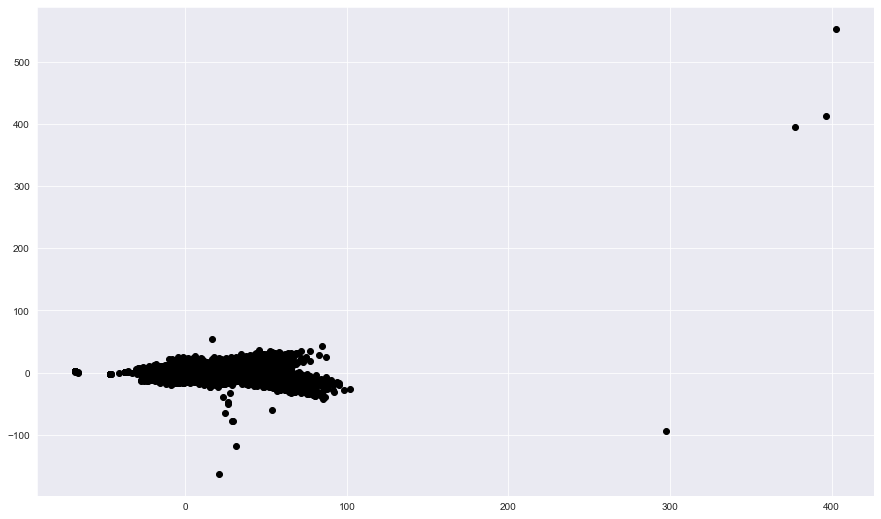

In [9]:
fig = plt.figure(figsize=(15, 9))
# ax = fig.add_subplot(111, projection='3d')

plt.scatter(read_data['x1'], read_data['x2'], color = 'black', label = 'pca')

In [10]:
train = read_data

In [11]:
motor_arr= [
    '03_04/VIB_0304_motor_51200.csv',
    '03_30/VIB_0330_motor_51200.csv',
    '03_31/VIB_0331_motor_51200.csv'
]

In [12]:
pump_arr= [
    '03_04/VIB_0304_pump_51200.csv',
    '03_30/VIB_0330_pump_51200.csv',
    '03_31/VIB_0331_pump_51200.csv'
]

In [13]:
def validation(valid_filepath,clf,coeficient=2):
    for file in valid_filepath:
        valid_set = pd.read_csv(file, encoding = 'cp949',sep = '\t')
        valid = data_process(valid_set.iloc[:47960000,1])
        valid = pca(valid)
        abnormal_set = valid_set.iloc[:47960000,1] * coeficient
        abnormal = data_process(abnormal_set)
        abnormal = pca(abnormal)
        plt.scatter(abnormal['x1'], abnormal['x2'], color = 'red', label = 'abnormal')
        plt.scatter(valid['x1'], valid['x2'], color = 'blue', label = 'normal')
        plt.savefig("scatter"+file[6:-4] + ".png")
        plt.show()
        
        anomaly_scores = get_anomaly_scores(clf,valid)
        anomaly_scores = pd.DataFrame(anomaly_scores.reshape(-1) ,columns=['x1'])
        
        outliers = get_anomaly_scores(clf,abnormal)
        outliers = pd.DataFrame(outliers.reshape(-1) ,columns=['x1'])
        
        #데이터 일부
        index = 100
        plt.figure(figsize=(10,5))

        plt.plot(outliers[:index].index,
                 outliers[:index],
                  color='red', label="anomaly")
        
        plt.plot(anomaly_scores[:index].index,
                 anomaly_scores[:index],
                  color='blue', label="normal")

        
        plt.grid()
        plt.savefig("graph_"+file[6:-4] + ".png")
        plt.show()
        
        #데이터 전범위
        plt.figure(figsize=(10,5))
        
        plt.plot(outliers.index,
                 outliers,
                  color='red', label="anomaly")

        plt.plot(anomaly_scores.index,
                 anomaly_scores,
                  color='blue', label="normal")

        plt.grid()
        plt.savefig("all_graph_"+file[6:-4] + ".png")
        plt.show()

In [21]:
# #scaling
# scaled_train = train
# scaled_valid = valid
# scaled_abnormal = abnormal

# min_max_scaler = preprocessing.MinMaxScaler()
# scaled_train = min_max_scaler.fit_transform(train)
# scaled_valid = min_max_scaler.fit_transform(valid)
# scaled_abnormal = min_max_scaler.fit_transform(abnormal)

#standard_scaler = preprocessing.StandardScaler()
# scaled_train = standard_scaler.fit_transform(train)
# scaled_valid = standard_scaler.fit_transform(valid)

# max_abs_scaler = preprocessing.MaxAbsScaler()
# scaled_train = scaling(train,max_abs_scaler)
# scaled_valid = scaling(valid,max_abs_scaler)
# scaled_abnormal = scaling(abnormal,max_abs_scaler)

In [14]:
from sklearn.neighbors import LocalOutlierFactor
#clf = IsolationForest(max_samples=10, contamination = 0.1, random_state=42)
clf = LocalOutlierFactor(n_neighbors=1000,novelty=True)

In [16]:
clf.fit(train)

LocalOutlierFactor(n_neighbors=1000, novelty=True)

100%|█████████████████████████████████████████████████████████████████████████████| 4726/4726 [00:08<00:00, 526.30it/s]


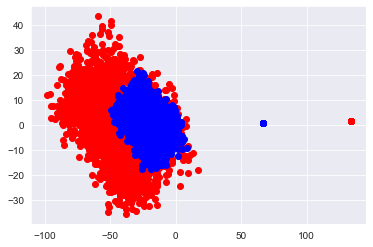

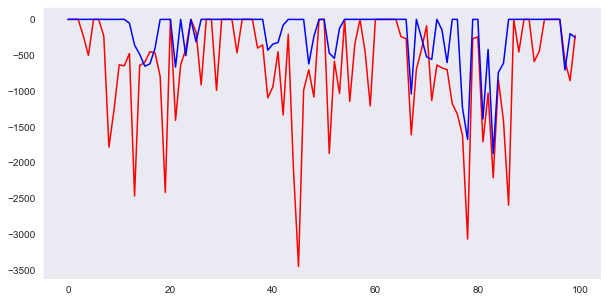

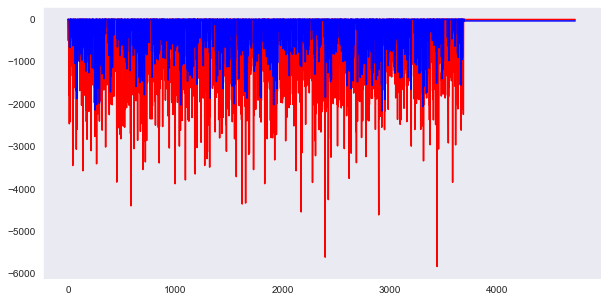

100%|█████████████████████████████████████████████████████████████████████████████| 9385/9385 [00:17<00:00, 525.47it/s]


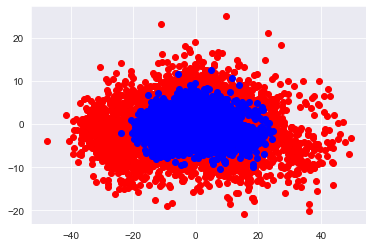

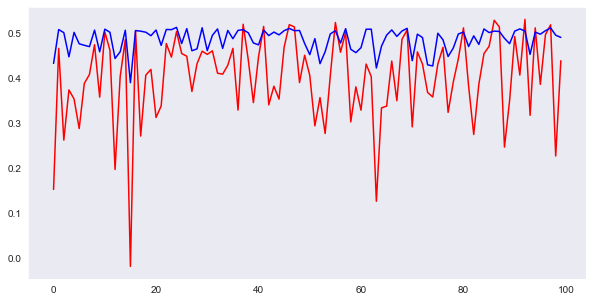

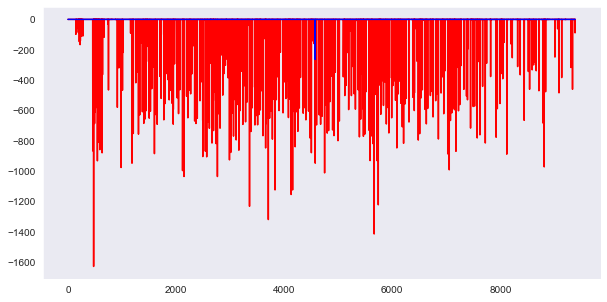

100%|█████████████████████████████████████████████████████████████████████████████| 9385/9385 [00:18<00:00, 519.85it/s]


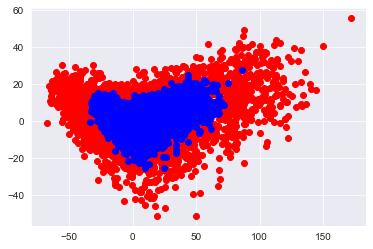

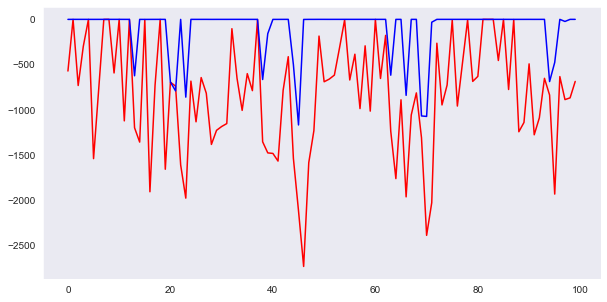

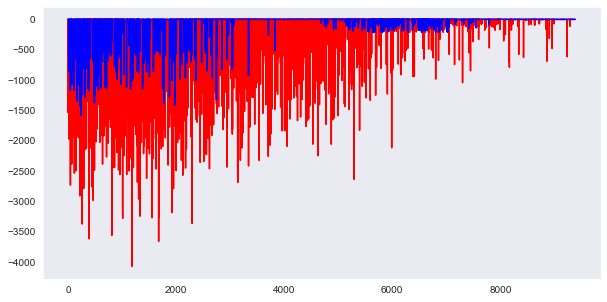

In [17]:
validation(pump_arr,clf,coeficient=2)

In [191]:
joblib.dump(clf, 'IF_Model_20220408_motor_minmax_2feature_v1.pkl') 

['IF_Model_20220408_motor_minmax_2feature_v1.pkl']

In [57]:
joblib.dump(min_max_scaler, 'IF_MinMaxScaler_20220406_pump_minmax_v1.pkl') 

['IF_MinMaxScaler_20220406_motor_minmax_v1.pkl']

In [195]:
clf = joblib.load('IF_Model_20220408_motor_minmax_2feature_v1.pkl')